#**Langsmith Langgraph Demo**
###**Poem Generation Apps**
* Apply topic and generate short poem
* login to https://smith.langchain.com/ to generate Langchain API Token
* View trash at langsmith site  : https://smith.langchain.com/

In [7]:
!pip install langchain-openai langgraph langsmith langgraph.prebuilt

In [4]:
# Retrieve the API key from Colab's secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
LANGCHAIN_API_KEY=  userdata.get('LANGCHAIN_API_KEY')
# Set as an ENVIROMENT VARIABLE
import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-demo"

#**Poem Generation With Analysis**

##**Tools**

In [11]:
def generate_poem(topic: str) -> str:
    """Generates a poem based on a topic."""
    return f"Roses are red,\nViolets are blue,\n{topic} is sweet,\nAnd so are you."

def classify_poem(poem: str) -> str:
    """Classifies a poem as 'good' or 'trash'."""
    # Dummy logic — you can replace with a real classifier
    return "trash" if "roses" in poem.lower() else "good"


##**Define the ReAct Agent Logic**

In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

tools = [generate_poem, classify_poem]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

sys_msg = SystemMessage(content="""
You are a creative assistant.
If the user asks for a poem, generate it using the 'generate_poem' tool.
Then classify it using 'classify_poem'.
If it's trash, generate a better one.
Finally, reply with a polished version in 30 words only.
""")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


 ## **LangGraph Structure**

In [14]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, StateGraph

builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile
poem_graph = builder.compile()


##**Invoke the Agent**

In [15]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Write me a poem about Kubernetes")]
result = poem_graph.invoke({"messages": messages})

# Display results
for msg in result["messages"]:
    msg.pretty_print()


================================ Human Message =================================

Write me a poem about Kubernetes
================================== Ai Message ==================================
Tool Calls:
  generate_poem (call_O0nJwKfXqevO2ACCbXcWqNwO)
 Call ID: call_O0nJwKfXqevO2ACCbXcWqNwO
  Args:
    topic: Kubernetes
================================= Tool Message =================================
Name: generate_poem

Roses are red,
Violets are blue,
Kubernetes is sweet,
And so are you.
================================== Ai Message ==================================
Tool Calls:
  classify_poem (call_AouzHamDJL68SJKVmzmdBpzB)
 Call ID: call_AouzHamDJL68SJKVmzmdBpzB
  Args:
    poem: Roses are red,
Violets are blue,
Kubernetes is sweet,
And so are you.
================================= Tool Message =================================
Name: classify_poem

trash
================================== Ai Message ==================================
Tool Calls:
  generate_poem (call_WO5z6Fsxhi

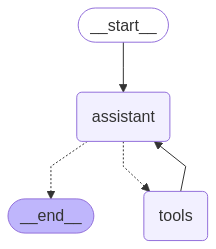

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


display(
    Image(
        poem_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## **Self Evaluation of Generated Poem ( max : 3 times)**


In [32]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Optional

class PoemState(BaseModel):
    poem: Optional[str] = None
    attempt_count: int = 0
    critique: Optional[str] = None


llm = ChatOpenAI(model="gpt-4o")  # Or "gpt-4", "gpt-3.5-turbo"

def generate_poem_node(state: PoemState):
    prompt = "Write a short, creative poem about clouds and dreams in 30 words."
    response = llm.invoke(prompt)
    return {
        "poem": response.content,
        "attempt_count": state.attempt_count + 1,
    }

def critique_poem_node(state: PoemState):
    critique_prompt = f"""
Here is a poem:
---
{state.poem}
---
Is this poem poetic and imaginative?
Reply ONLY with "good" or "bad".
"""
    response = llm.invoke(critique_prompt)
    return {
        "critique": response.content.strip().lower()
    }

def decide_next_node(state: PoemState):
    if state.critique == "bad" and state.attempt_count < 3:
        return "generate_poem"
    return "finish"

# Provide the state schema here!
builder = StateGraph(state_schema=PoemState)

builder.add_node("generate_poem", RunnableLambda(generate_poem_node))
builder.add_node("critique_poem", RunnableLambda(critique_poem_node))

builder.set_entry_point("generate_poem")
builder.add_edge("generate_poem", "critique_poem")
builder.add_conditional_edges("critique_poem", decide_next_node)

graph_f = builder.compile()

# Initialize the state
state = PoemState()

result = graph_f.invoke(state)

print("\n🎉 Final Poem:\n")
print(result['poem'])
print("\n✅ Attempts:", result['attempt_count'])
print("📋 Critique:", result['critique'])



🎉 Final Poem:

In the sky, soft whispers stream,  
Clouds weaving tapestries of dream.  
Floating on a twilight breeze,  
Carrying wishes through the trees.  
In their dance, hopes are spun,  
Dreams and clouds blend as one.  

✅ Attempts: 1
📋 Critique: good


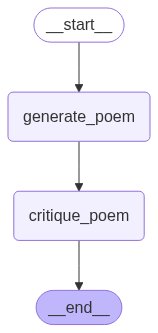

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod


display(
    Image(
        graph_f.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)